In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pycolmap
from pathlib import Path
from tqdm import tqdm

In [6]:
# Set your image directory path here
IMAGE_DIR = "images"  # Replace with your actual image folder path

# Output directories
OUTPUT_DIR = "colmap_output"
FEATURE_DIR = os.path.join(OUTPUT_DIR, "features")
DATABASE_PATH = os.path.join(OUTPUT_DIR, "database.db")
RECONSTRUCTION_PATH = os.path.join(OUTPUT_DIR, "reconstruction")

In [7]:
# Create output directories if they don't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(FEATURE_DIR, exist_ok=True)
os.makedirs(RECONSTRUCTION_PATH, exist_ok=True)

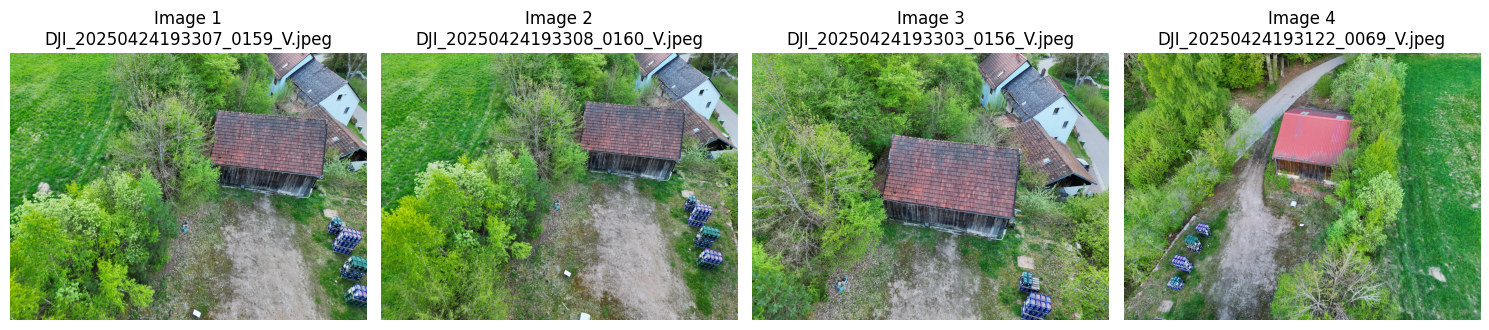

Found 7 images in the directory.


In [8]:
def show_sample_images(image_dir, num_samples=4):
    """Display some sample images from the dataset"""
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) 
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_paths:
        print("No images found in the directory!")
        return
    
    # Select a sample of images
    if len(image_paths) > num_samples:
        sample_paths = np.random.choice(image_paths, num_samples, replace=False)
    else:
        sample_paths = image_paths
    
    # Plot the sample images
    fig, axes = plt.subplots(1, min(num_samples, len(sample_paths)), figsize=(15, 5))
    if len(sample_paths) == 1:
        axes = [axes]
    
    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}\n{os.path.basename(img_path)}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Found {len(image_paths)} images in the directory.")
    return image_paths

# Display sample images
image_paths = show_sample_images(IMAGE_DIR)

In [9]:
# Extract SIFT features
print("Extracting features...")
pycolmap.set_random_seed(0)
pycolmap.extract_features(DATABASE_PATH, IMAGE_DIR)

Extracting features...


In [11]:
pycolmap.match_exhaustive(DATABASE_PATH)

In [19]:

def incremental_mapping_with_pbar(database_path, image_path, sfm_path):
    num_images = pycolmap.Database(database_path).num_images
    
    # Create a progress bar placeholder
    pbar = tqdm(total=num_images, desc="Images registered:")
    pbar.update(0)
    
    # Define callback functions that update the progress bar
    def initial_pair_callback():
        pbar.update(2)
    
    def next_image_callback():
        pbar.update(1)
    
    try:
        reconstructions = pycolmap.incremental_mapping(
            database_path,
            image_path,
            sfm_path,
            initial_image_pair_callback=initial_pair_callback,
            next_image_callback=next_image_callback,
        )
    finally:
        # Ensure the progress bar is closed even if an exception occurs
        pbar.close()
    
    return reconstructions

In [20]:
recs = incremental_mapping_with_pbar(DATABASE_PATH, IMAGE_DIR, RECONSTRUCTION_PATH)

Images registered:: 100%|███████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.24s/it]


In [46]:
reconstruction = recs[0]

In [45]:
import open3d as o3d
import numpy as np

xyz = np.array([p.xyz for p in reconstruction.points3D.values()])
pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz))
o3d.visualization.draw_geometries([pcd])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [53]:
image_id = 1
image = reconstruction.images[image_id]
camera = reconstruction.cameras[5]
point2D = image.points2D[1001]
point2D

Point2D(xy=[2056.27, 620.284], point3D_id=-1)

In [60]:
image.get_observation_points2D()

ListPoint2D[Point2D(xy=[3052.96, 72.4755], point3D_id=3485), Point2D(xy=[3772.69, 94.0983], point3D_id=3478), Point2D(xy=[3750.27, 133.05], point3D_id=3486), Point2D(xy=[3278.43, 151.783], point3D_id=3487), Point2D(xy=[3629.48, 158.469], point3D_id=3587), Point2D(xy=[3025.12, 168.372], point3D_id=3489), Point2D(xy=[3025.12, 168.372], point3D_id=3490), Point2D(xy=[3026.72, 199.974], point3D_id=3493), Point2D(xy=[3705.05, 223], point3D_id=3491), Point2D(xy=[3353.33, 258.241], point3D_id=3499), Point2D(xy=[3336.39, 302.755], point3D_id=3471), Point2D(xy=[3203.52, 317.457], point3D_id=3500), Point2D(xy=[3629.33, 320.539], point3D_id=3007), Point2D(xy=[3629.33, 320.539], point3D_id=3008), Point2D(xy=[3502.36, 321.76], point3D_id=3087), Point2D(xy=[3598.35, 332.847], point3D_id=3088), Point2D(xy=[3180.85, 341.903], point3D_id=3479), Point2D(xy=[3421.04, 351.385], point3D_id=3009), Point2D(xy=[3224.45, 385.022], point3D_id=3480), Point2D(xy=[3420.34, 566.471], point3D_id=3010), Point2D(xy=[24

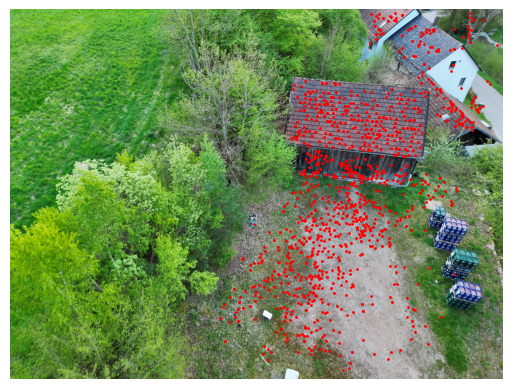

In [62]:
import matplotlib.pyplot as plt

# Get 2D points for all observations in the image
image = reconstruction.images[image_id]
observations = image.get_observation_points2D()

# Get 2D points from observations
points_2d = [obs.xy for obs in observations if obs.point3D_id != -1]

# Plot the 2D points on the image
img_path = os.path.join(IMAGE_DIR, image.name)
img = Image.open(img_path)
plt.imshow(img)
plt.scatter(*zip(*points_2d), color='red', s=1)  # Red points
plt.axis('off')
plt.show()